In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/drive/MyDrive/parent_TRAIN_VAL_AUGMENTED/augmeneted_latest_4_class", output="train_val-augmented",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 3101 files [00:56, 54.69 files/s] 


In [5]:
train_dir = "/content/train_val-augmented/train"
val_dir = "/content/train_val-augmented/val"
test_dir = "/content/drive/MyDrive/parent_TRAIN_VAL_AUGMENTED/test"

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                          # featurewise_center=True,
                                                          # featurewise_std_normalization=True,
                                                          # rotation_range=90,
                                                          # width_shift_range=0.2,
                                                          # height_shift_range=0.2,
                                                          # horizontal_flip=True,
                                                          # zoom_range=0.2,
                                                          )

In [7]:
train_gen = datagen.flow_from_directory(train_dir,
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                        shuffle=True,
                                                 class_mode = 'categorical')
test_gen= datagen.flow_from_directory(test_dir,
                                            target_size = (224,224),
                                            batch_size = 32,
                                      shuffle=False,
                                            class_mode ='categorical')
val_gen = datagen.flow_from_directory(val_dir,
                                            target_size = (224,224),
                                            batch_size = 32,
                                      shuffle=True,
                                          class_mode = 'categorical')

Found 2479 images belonging to 4 classes.
Found 79 images belonging to 4 classes.
Found 622 images belonging to 4 classes.


In [8]:
# IMG_SIZE = (224, 224)

# train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  shuffle=True,
#                                                                  batch_size=32)


# test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  batch_size=32,
#                                                                 shuffle=False)

# val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  batch_size=32,
#                                                                 shuffle=True)

In [9]:
# Visualizing data
import os 
def visualize_random_images(dataset_type="train", label_type="Monkeypox"):
    
    sample = 9
    
    plt.figure(figsize=(15, 8))
    type_dir = train_dir if dataset_type=="train" else test_dir
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

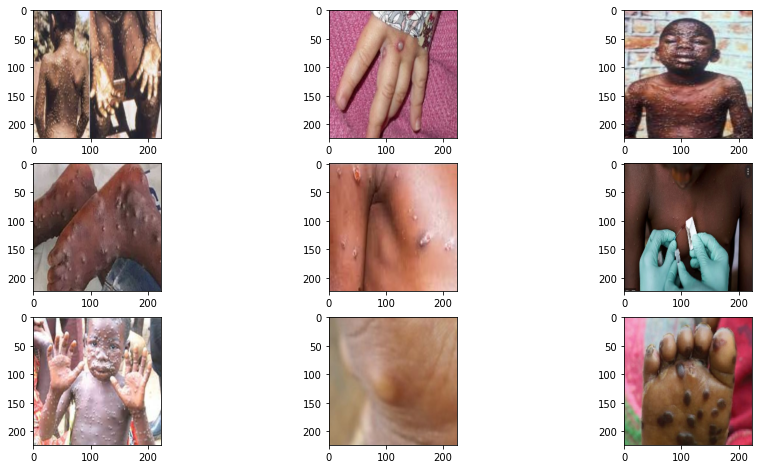

In [10]:
visualize_random_images("/content/train_val-augmented/train/monkeypox_TV_augmented/dr_0_1404.jpg")

In [11]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [12]:
base_model = tf.keras.applications.EfficientNetB1(include_top=False)
base_model.trainable = False

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = layers.Dropout(0.2)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(512, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(512, activation="relu")(dropout_layer_2)
outputs = layers.Dense(4, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)
model.summary()

27033600/27018416 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                              

In [13]:
# base_model = tf.keras.applications.MobileNetV2(include_top=False)
# base_model.trainable = False

# for layer in base_model.layers[:-5]:
#   layer.trainable = False

# inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
# base_layer = base_model(inputs)

# flat_layer = layers.Flatten()(base_layer)

# outputs = layers.Dense(4, activation="softmax")(flat_layer)
# model = Model(inputs, outputs)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_gen,
                       epochs=40,
                       validation_data=val_gen)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
78/78 [==============================] - 42s 164ms/step - loss: 1.3678 - accuracy: 0.7729 - val_loss: 0.3866 - val_accuracy: 0.9003
Epoch 2/40
78/78 [==============================] - 9s 121ms/step - loss: 0.2906 - accuracy: 0.9274 - val_loss: 0.4301 - val_accuracy: 0.8971
Epoch 3/40
78/78 [==============================] - 9s 120ms/step - loss: 0.2738 - accuracy: 0.9427 - val_loss: 0.4684 - val_accuracy: 0.9035
Epoch 4/40
78/78 [==============================] - 9s 119ms/step - loss: 0.2238 - accuracy: 0.9589 - val_loss: 0.3639 - val_accuracy: 0.9277
Epoch 5/40
78/78 [==============================] - 10s 131ms/step - loss: 0.1315 - accuracy: 0.9762 - val_loss: 0.3079 - val_accuracy: 0.9341
Epoch 6/40
78/78 [==============================] - 10s 121ms/step - loss: 0.1444 - accuracy: 0.9726 - val_loss: 0.4241 - val_accuracy: 0.9373
Epoch 7/40
78/78 [==============================] - 10s 124ms/step - loss: 0.1367 - accuracy: 0.9742 - val_loss: 0.3765 - val_accuracy: 0.9502
Ep

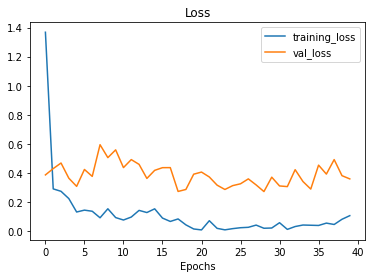

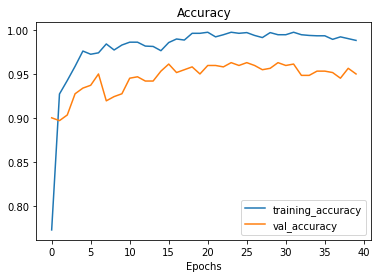

In [15]:
plot_loss_curves(history)

In [16]:
# model.evaluate(test_data)

In [17]:
# y_pred = tf.math.round(model.predict(test_gen))
# y_true = []
# for images, labels in test_gen.unbatch():
#   y_true.append(labels.numpy())

In [18]:
# accuracy_score(y_true, y_pred)

In [19]:
# print(classification_report(y_true, y_pred, target_names=train_data.class_names))

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from keras.utils.np_utils import to_categorical
import numpy as np
print("==============TEST RESULTS============")

num_classes = len(train_gen.class_indices)
test_labels = test_gen.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)
y_true = [i.argmax() for i in test_labels]

predictions = model.predict(test_gen, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
confusion_mtx = confusion_matrix(true_classes, yPredictions) 
y_pred_probabilities=yPredictions
classnames=[]
for classname in test_gen.class_indices:
    classnames.append(classname)

target_names = classnames
print(classification_report(true_classes, yPredictions, target_names=target_names,digits=4))

# print('roc_auc_score = ' + str(roc_auc_score( true_classes, yPredictions)))

==============TEST RESULTS============
3/3 [==============================] - 39s 18s/step
              precision    recall  f1-score   support

  Chickenpox     0.5556    0.9091    0.6897        11
     Measles     0.7692    1.0000    0.8696        10
   Monkeypox     0.9444    0.6071    0.7391        28
      Normal     0.9667    0.9667    0.9667        30

    accuracy                         0.8354        79
   macro avg     0.8090    0.8707    0.8163        79
weighted avg     0.8766    0.8354    0.8352        79



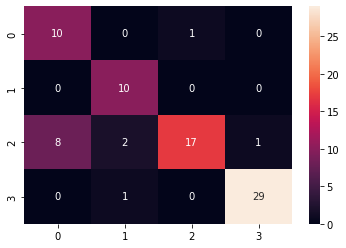

In [21]:

sns.heatmap(confusion_mtx.astype("int"), annot=True)

In [22]:
model.save('monkeypox_EfficientNetB3_with_Transferlearnig_on_Augmented_95.h5')